In [17]:
# librerias
import cv2 
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy import ndimage, datasets
import scipy.io

1. Abra la imagen según el formato en el que fue guardada, muestre dimensiones y visualice. Si no está, pase a monocroma. La imagen ha sufrido un contratiempo inadecuado, identifique cual es describa y realice la o las operaciones que crea adecuadas para acondicinar la imagen y seguir trabajando con ella, justifique. En la imagen acondicionada debe detectar y segmentar el tumor o lesión del resto de la imagen. Muestre el resultado en una imagen binaria.

dimensiones:  (1426, 1426, 3)
dtype:  uint8


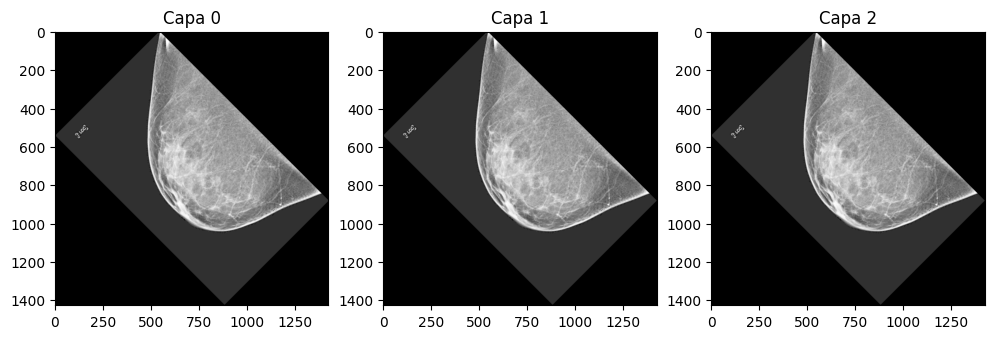

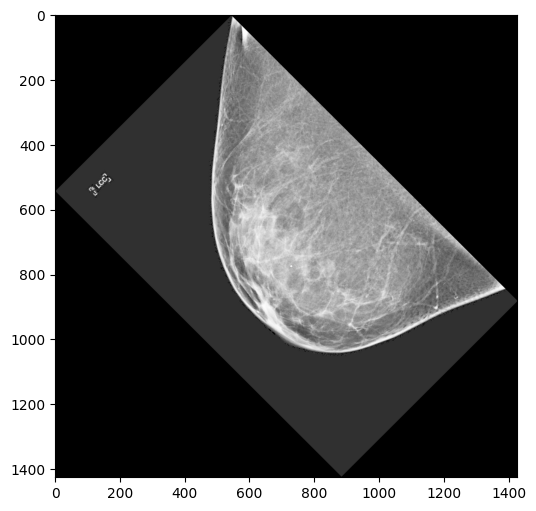

In [18]:
# cargo imagen en una variable
img = cv2.imread("IMAGEN.png")

# muestro dimensiones
print("dimensiones: ", img.shape)
# muestro tipo de dato
print("dtype: ", img.dtype) 

# visualizamos la imagen en sus diferentes capas
plt.figure(figsize=(12,6))

plt.subplot(131)
plt.title("Capa 0")
plt.imshow(img[:,:,0], cmap='gray')


plt.subplot(132)
plt.title("Capa 1")
plt.imshow(img[:,:,1], cmap='gray')


plt.subplot(133)
plt.title("Capa 2")
plt.imshow(img[:,:,2], cmap='gray')

plt.show()

plt.figure(figsize=(12,6))
plt.imshow(img, cmap='gray')

# me quedo con la capa 0
imgs = img[:,:,0]

## Contratiempo

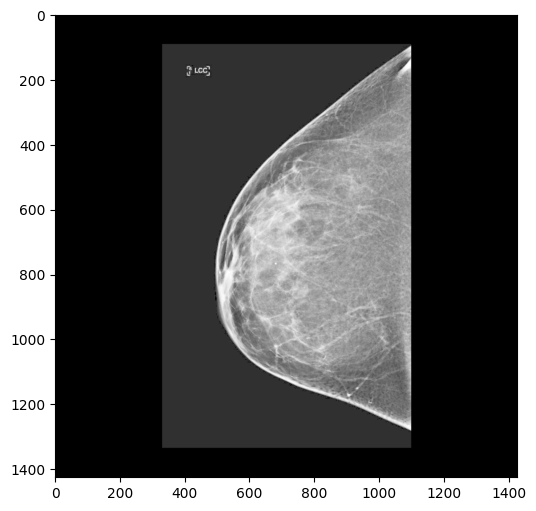

In [19]:
# el contratiempo encontrado es que la imagen esta rotada
# hacemos una rotacion para volver la imagen a su tamano

# obtenemos el tamano de la senal
fil, col = imgs.shape

# obtenemos la matriz de la transformacion geometrica de rotacion
matRotac = cv2.getRotationMatrix2D((fil/2,col/2), -45,1)

# aplicamos la transformacion
imgsRotada = cv2.warpAffine(imgs, matRotac, (col,fil))

# mostramos la imagen rotada
plt.figure(figsize=(12,6))
plt.imshow(imgsRotada, cmap='gray')

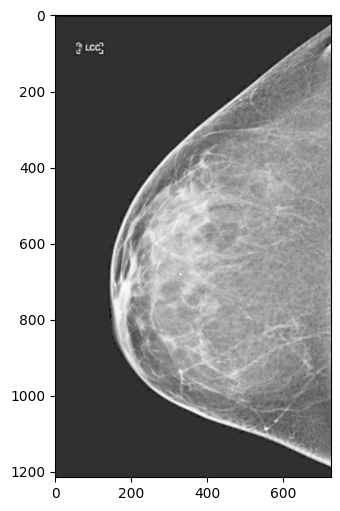

In [22]:
# ahora recorto los bordes negros sobrantes
imgs_final = imgsRotada[85:1300,350:1075]

plt.figure(figsize=(12,6))
plt.imshow(imgs_final, cmap='gray')

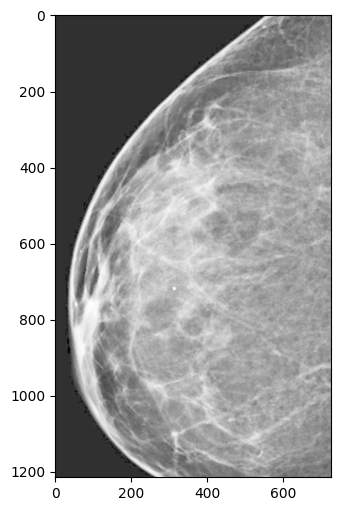

In [32]:
# se procede a hacer un leve escalado dado que creo que el tumor esta en la parte central de la imagen

# reescribo los valores de col y fil que no son los mismos
# dado que se recorto la imagen
fil, col = imgs_final.shape
escMatrix = cv2.getRotationMatrix2D((col/2,fil/2), 0, 1.5)

imgsEsc = cv2.warpAffine(imgs_final, escMatrix, (col,fil))

plt.figure(figsize=(12,6))
plt.imshow(imgsEsc, cmap='gray')

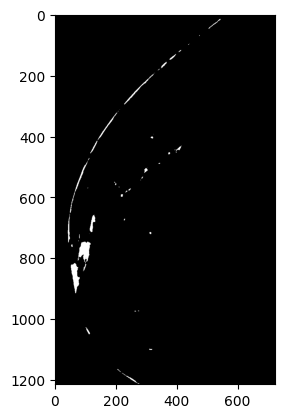

In [38]:
# se procede primero a aplicar una transformacion punto a punto
# de binarizado para aislar el tumor

umbral = (imgsEsc>=237)

plt.imshow(umbral, cmap='gray')

Descartando el borde, podemos observar una anormalidad que se observa en la zona central que destacan del resto del tejido mamario, dado que se observa una intensidad muy alta (alto reflejo de los rayos X). 
El umbral utilizado es de 237 en escala de grises uint8.'

Sin embargo, considero que es demasiado grande la marca observada por lo que se procede a aplicar filtros de borde para ver si obtenemos una mejor imagen del posible problema:


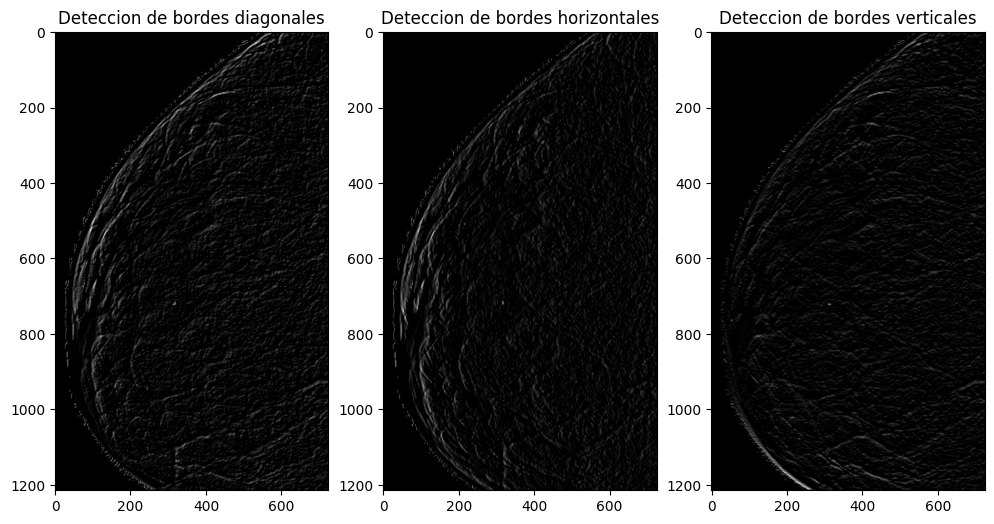

In [44]:
# se utilizan filtros de Prewitt para deteccion de bordes
kpd = np.array([[1, 1, 0], [1, 0, -1], [0, -1, -1]]) # prewitt diagonal
kph = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]]) # prewitt vertical
kpv = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]]) # prewitt horizontal

bordesDiag = cv2.filter2D(imgsEsc, -1, kpd)
bordesHoriz = cv2.filter2D(imgsEsc, -1, kph)
bordesVert = cv2.filter2D(imgsEsc, -1, kpv)

plt.figure(figsize=(12,6))

plt.subplot(131)
plt.title("Deteccion de bordes diagonales")
plt.imshow(bordesDiag, cmap='gray')


plt.subplot(132)
plt.title("Deteccion de bordes horizontales")
plt.imshow(bordesHoriz, cmap='gray')


plt.subplot(133)
plt.title("Deteccion de bordes verticales")
plt.imshow(bordesVert, cmap='gray')

plt.show()



Ahora se aplicara una umbralizacion nuevamente a la deteccion de bordes diagonales, donde se observa un pequeno punto.

uint8


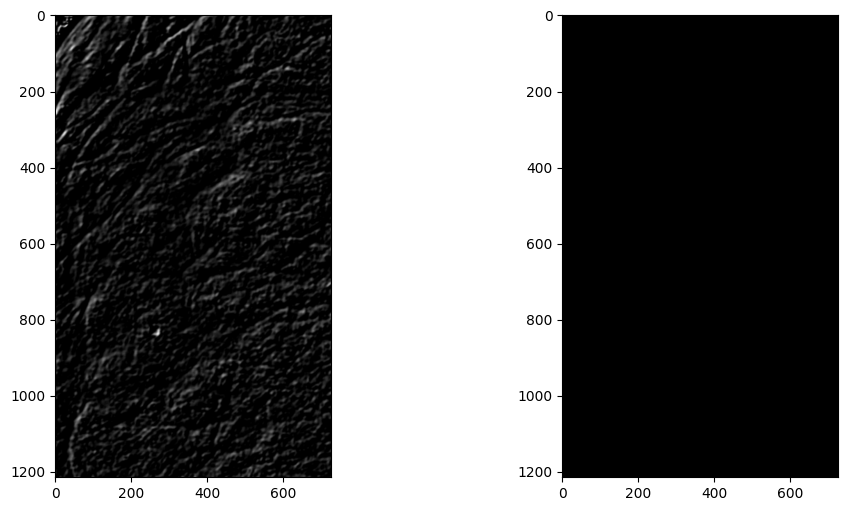

In [57]:
# se escala en el centro
escalado2 = cv2.getRotationMatrix2D((col/2,fil/2), 0, 2)

umbral2 = cv2.warpAffine(bordesDiag,escalado2, (col,fil))


print(bordesDiag.dtype)
deteccion_final = (umbral2>=250)

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(umbral2, cmap='gray')

plt.subplot(122)
plt.imshow(deteccion_final, cmap='gray')

plt.show()

2. Explique que técnicas utilizó en cada paso y por que? Es deconvolución? es un filtro lineal o no lineal?  pasa bajo o pasa alto? Es una transformación punto a punto? geométrica? Justifique los si y no que conteste en relación al problema. Si usó filtro, y lo cree adecuado, verifique utilizando la transformada de Fourier (para esto tenga en cuenta las dimensiones de la imagen y el filtro) .Explique con sus palabras como funciona la técnica que utilizó tanto en el espacio como en el dominio de la frecuencia si corresponde.

Lo primero que se realizo fue una rotacion de la imagen. 
Esto se realizo dado que es preferible observar la imagen como fue tomada. Para ello se usa una **transformacion geometrica del tipo rotacion**.

Una vez rotada la imagen, se eliminan los bordes sobrantes y se hace una **transformacion geometrica de escalado** para poder observar la imagen con mas comodidad. 

Ambas transformaciones utilizan una _matriz de transformacion_, generada con el metodo <code>cv2.getRotationMatrix2D()</code>, que permite hacer ambas transformaciones geometricas simultaneamente.
Luego, se aplica la transfromacion con el metodo <code>cv2.warpAffine()</code>.

### Umbralizado primero

Se aplico un filtro de binarizacion/umbralizado. Esta es una **transformacion punto a punto** que permite:
- Pasar la intensidad del pixel al maximo si cumple la condicion de umbral.
- Pasar la intensidad del pixel al minimo si no cumple con la condicion de umbral. 

De dicha manera me quedo con los valores mas claros de la imagen. Al tratarse de una imagen de rayos X, nos quedamos con la informacion de rayos electromagneticos que rebotan y no llegan a la pelicula. Generalmente, masas de alta densidad como huesos, tumores, calcificaciones. 

### Filtros de bordes
Se aplicaron los **filtros de prewitt** para bordes. Estos son un tipo de filtro pasa alto, que resaltan los bordes en la direccion especificada al generar el Kernel.

Se genera el kernel o mascara y se aplica el metodo <code>cv2.filter2D()</code> para cada tipo de borde, obteniendo una imagen muy clara de lo que se cosidera una calsificacion. 
Asi, descartamos que el primer umbralizado/binarizado sea lo mas preciso, dado que al ser un parametro muy amplio el umbral, me muestra informacion que no es relevante. El filtro de bordes es mucho mas preciso, como se ve en las imagenes.

Finalmente se realizo un escalado mas para observar el problema. 
Se intento realizar un segundo umbral para aislar definitivamente el problema, pero por algun motivo no se obtiene un resaltado del mismo.


3. en alguno de los pasos realizados compare dos elecciones de técnicas, parámetros, filtros u opciones. Justifique cual elige.

Se compara el uso de filtros direccionales (lineales) y de la transformacion punto a punto de umbralizado/binarizado.

- El binarizado fue util en un principio para determinar que zonas de la imagen podrian contener un problema. Sin embargo, al utilizar un algoritmo de _"fuerza bruta"_, dado que hay un solo parametro de umbralizado, y a los pixeles los convierte directamente al maximo o al minimo, hay muchas partes que se resaltan de la imagen, y que al final, con el uso de la siguiente tecnica resultaron ser lo que parece tejido mamario/nervioso o adiposo. En conclusion, es util en un principio, pero no es muy util para obtener un diagnostico mas preciso.
- Filtros de prewitt mejoraron la observacion del problema, dado que resaltan cambios bruscos y mas aislados. Ademas, permitieron ver de forma mucho mas clara partes que, si bien en el umbralizado parecian algo problematico, no era mas que tejido sano, en principio.